In [1]:
import torch

In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image = cv2.imread('anime.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)

In [26]:
def show(image):
  plt.imshow(image)

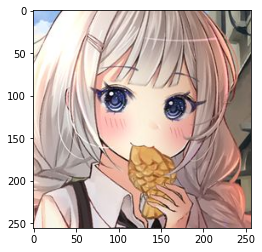

In [27]:
show(image)

In [28]:
def detect_edges( img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.bilateralFilter(img_gray, 5, 50, 50)
        img_gray_edges = cv2.Canny(img_gray, 65, 110)
        img_gray_edges = cv2.bitwise_not(img_gray_edges) # invert black/white
        img_edges = cv2.cvtColor(img_gray_edges, cv2.COLOR_GRAY2RGB)
        return img_edges

In [30]:
cv2.imwrite('edges.png', edges)

True

In [75]:
 import random
def _draw_color_circles_on_src_img(img_src, img_target):
    non_white_coords = _get_non_white_coordinates(img_target)
    for center_y, center_x in non_white_coords:
        _draw_color_circle_on_src_img(img_src, img_target, center_y, center_x)

def _get_non_white_coordinates( img):
    non_white_mask = np.sum(img, axis=-1) < 2.75
    non_white_y, non_white_x = np.nonzero(non_white_mask)
    # randomly sample non-white coordinates
    choices = [600]
    n_non_white = len(non_white_y)
    print(n_non_white)
    n_color_points = min(n_non_white, random.choice(choices))
    idxs = np.random.choice(n_non_white, n_color_points, replace=False)
    non_white_coords = list(zip(non_white_y[idxs], non_white_x[idxs]))
    return non_white_coords

def _draw_color_circle_on_src_img( img_src, img_target, center_y, center_x):
    assert img_src.shape == img_target.shape, "Image source and target must have same shape."
    y0, y1, x0, x1 = _get_color_point_bbox_coords(center_y, center_x)
    color = np.mean(img_target[y0:y1, x0:x1], axis=(0, 1))
    img_src[y0:y1, x0:x1] = color

def _get_color_point_bbox_coords(center_y, center_x):
    radius = 2
    y0 = max(0, center_y-radius+1)
    y1 = min(256, center_y+radius)
    x0 = max(0, center_x-radius+1)
    x1 = min(256, center_x+radius)
    return y0, y1, x0, x1

In [32]:
def mark(img_gray, image):
    img_gray = (img_gray - 127.5)/127.5
    image = (image - 127.5)/127.5
    _draw_color_circles_on_src_img(img_gray, image)
    img_gray = (img_gray * 127.5) + 127.5
    image = (image * 127.5) + 127.5

    return img_gray.astype('uint8')

In [35]:
import torch
import torch.nn as nn
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels , 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        self.apply(weights_init_normal)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

In [36]:
sketch_model = GeneratorUNet().cuda()

In [37]:
cp = torch.load('sketch.tar')

In [38]:
sketch_model.load_state_dict(cp['G'])

<All keys matched successfully>

In [39]:
sketch_model.eval()

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [40]:
from PIL import Image
import torchvision.transforms as transforms
transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(3)], [0.5 for _ in range(3)]),
    ]
)
def sketch_API(edges):
    image = Image.fromarray(np.uint8(edges)).convert('RGB')
    inp = transforms(image)
    inp = inp.cuda()
    out = sketch_model(inp.reshape(1, 3, 256, 256))
    np_image = out.detach().cpu().numpy()[0].transpose(1, 2, 0)
    return (np_image * 127.5 + 127.5).astype('uint8')

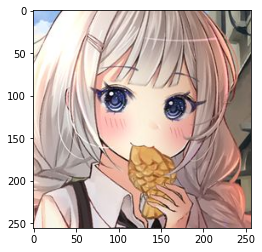

In [114]:
show(image)

In [112]:
edges = detect_edges(image)

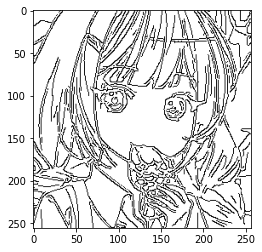

In [113]:
show(edges)

In [81]:
bw_edges = sketch_API(edges)

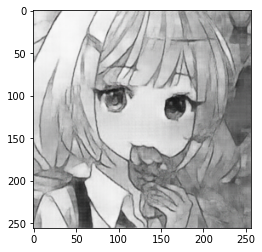

In [82]:
show(bw_edges)

In [44]:
no_food = cv2.imread('edges_modified.png')
no_food = cv2.cvtColor(no_food, cv2.COLOR_BGR2RGB)
no_food = cv2.resize(no_food, (256, 256), interpolation = cv2.INTER_AREA)

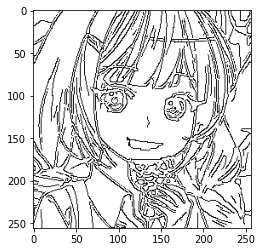

In [111]:
show(no_food)

In [45]:
bw_no_ice = sketch_API(no_food)

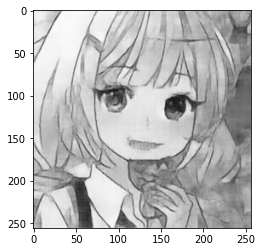

In [46]:
show(bw_no_ice)

In [55]:
color_model = GeneratorUNet().cuda()
cp = torch.load('color.tar')
color_model.load_state_dict(cp['G'])
color_model.eval()

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [100]:
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(3)], [0.5 for _ in range(3)]),
    ]
)

def color_API(edges):
    image = Image.fromarray(np.uint8(edges)).convert('RGB')
    inp = transforms(image)
    inp = inp.cuda()
    out = color_model(inp.reshape(1, 3, 256, 256))
    vutils.save_image(out.data, 'fake_image.png')
    np_image = out.detach().cpu().numpy()[0].transpose(1, 2, 0)
    img =  (np_image * 127.5 + 127.5).astype('uint8')
    dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    return dst, img

In [101]:
marked = mark(bw_edges, image)

61609


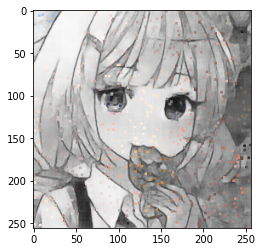

In [102]:
show(marked)

In [103]:
color_edges, not_denoised = color_API(marked)

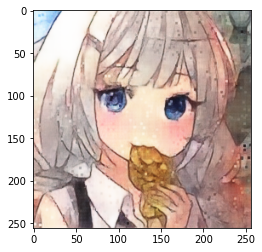

In [104]:
show(not_denoised)

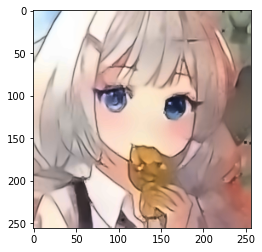

In [95]:
show(color_edges)

In [105]:
marked = mark(bw_no_ice, image)

61609


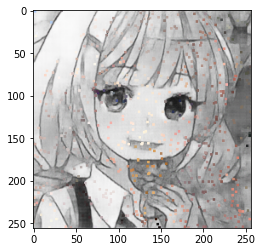

In [106]:
show(marked)

In [108]:
color_edges, not_denoised = color_API(marked)

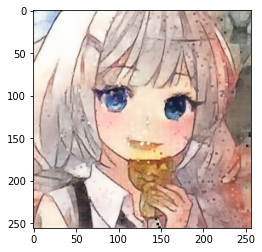

In [109]:
show(not_denoised)

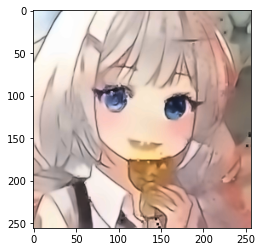

In [110]:
show(color_edges)